In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib as mlp
import matplotlib.patches as mpatches
import os
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from sqlalchemy import desc

In [3]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [8]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
recent_row = session.query(Measurement).first()
recent_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fc8c7706040>,
 'date': '2010-01-01',
 'prcp': 0.08,
 'id': 1,
 'station': 'USC00519397',
 'tobs': 65.0}

In [10]:
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
# Find the most recent date in the data set.
recent_row = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_row

('2017-08-23')

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_ago

datetime.date(2016, 8, 23)

In [13]:
# Perform a query to retrieve the data and precipitation scores

prcp_year_aug_16_17 = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).\
    order_by(Measurement.date).all()

prcp_year_aug_16_17 = pd.DataFrame(prcp_year_aug_16_17)

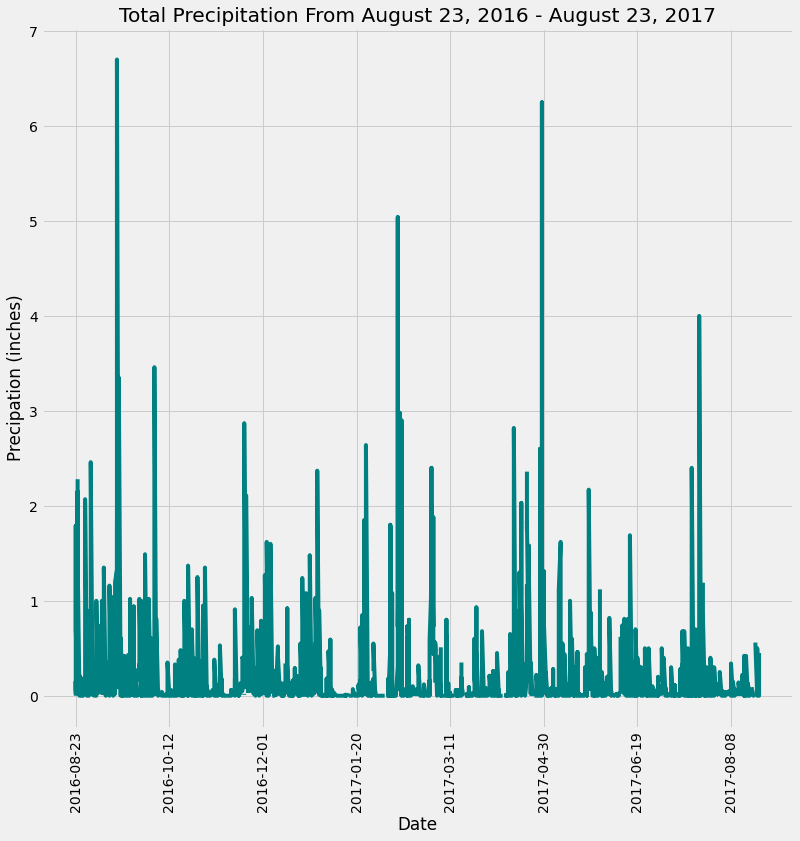

In [14]:
fig, ax = plt.subplots(figsize=(12,12))

ax.plot(prcp_year_aug_16_17['date'],prcp_year_aug_16_17['prcp'],color='teal')
ax.set(xlabel="Date",ylabel="Precipation (inches)", title = "Total Precipitation From August 23, 2016 - August 23, 2017")
ax.xaxis.set_major_locator(plt.MaxNLocator(9))
plt.xticks(rotation = 90)
plt.show()



In [15]:
 #Use Pandas to print the summary statistics for the precipitation data.

 prcp_year_aug_16_17.describe()


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number stations in the dataset
recent_row = session.query(Station).first()
recent_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fc8c8271820>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'longitude': -157.8168,
 'station': 'USC00519397'}

In [17]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [18]:
station_count = session.query(Station).distinct(Station.station, Station.name).count()

print(f'There are {station_count} stations in the dataset.')

There are 9 stations in the dataset.


In [19]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_sts = session.query(Measurement.station,func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()
print(f'The most active stations by record count are {active_sts}.')

The most active stations by record count are [('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)].


In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_st = active_sts[0][0]
active_st_min = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()


active_st_max = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()


active_st_mean = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()


print(f'USC00519281 lowest recorded temperature was {active_st_min} degrees.')
print(f'USC00519281 highest recorded temperature was {active_st_max} degrees.')
print(f'USC00519281 had an average temperature of {active_st_mean} degrees.')

USC00519281 lowest recorded temperature was [(54.0,)] degrees.
USC00519281 highest recorded temperature was [(85.0,)] degrees.
USC00519281 had an average temperature of [(71.66378066378067,)] degrees.


In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_st_year = session.query(Measurement.station, Measurement.tobs, Measurement.date).\
                filter(Measurement.station == most_active_st).\
                filter(Measurement.date >= year_ago).all()
active_st_year_df = pd.DataFrame(active_st_year)
active_st_year_df.head()

,station,tobs,date
0,USC00519281,77.0,2016-08-23
1,USC00519281,77.0,2016-08-24
2,USC00519281,80.0,2016-08-25
3,USC00519281,80.0,2016-08-26
4,USC00519281,75.0,2016-08-27


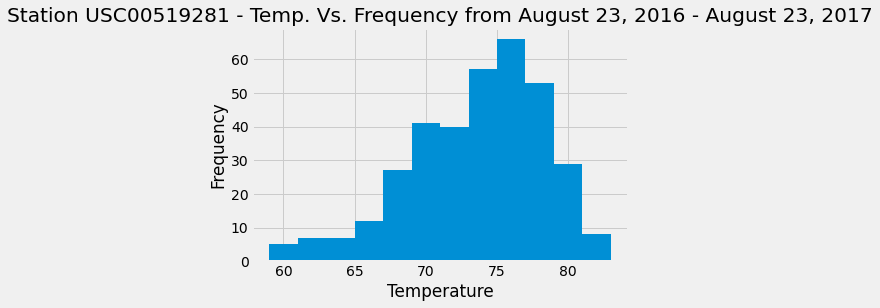

In [22]:
active_st_year_df.hist(bins=12)

plt.title("Station USC00519281 - Temp. Vs. Frequency from August 23, 2016 - August 23, 2017")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close session

In [23]:
# Close Session
session.close()